In [1]:
class PyTorchGMM:
    def __init__(self, n_components, max_iter=200, tol=1e-8, reg_covar=1e-6, random_state=42):
        self.n_components, self.max_iter, self.tol = n_components, max_iter, tol
        self.reg_covar, self.random_state = reg_covar, random_state
        self.device = DEVICE
        self.weights_, self.means_, self.covariances_ = None, None, None
        self.converged_ = False
        self.log_likelihood_ = -torch.inf

    def fit(self, X, initial_means=None):
        if self.random_state: torch.manual_seed(self.random_state)
        X = X.to(self.device)
        n_samples, n_features = X.shape
        self._initialize_parameters(X, initial_means)
        log_likelihood = -torch.inf
        for i in range(self.max_iter):
            prev_log_likelihood = log_likelihood
            log_prob_norm, log_responsibilities = self._e_step(X)
            self._m_step(X, log_responsibilities)
            log_likelihood = torch.mean(log_prob_norm)
            if i > 0 and torch.abs(log_likelihood - prev_log_likelihood) < self.tol:
                self.converged_ = True
                break
        if not self.converged_: print(f"Warning: GMM with {self.n_components} components did not converge.")
        self.log_likelihood_ = torch.sum(log_prob_norm).item()

    def _initialize_parameters(self, X, initial_means):
        n_samples, n_features = X.shape
        if initial_means is not None and initial_means.shape == (self.n_components, n_features):
            self.means_ = initial_means.to(self.device)
        else:
            indices = torch.randperm(n_samples, device=self.device)[:self.n_components]
            self.means_ = X[indices]
        self.weights_ = torch.full((self.n_components,), 1/self.n_components, device=self.device)
        self.covariances_ = torch.eye(n_features, device=self.device).unsqueeze(0).repeat(self.n_components, 1, 1)

    def _e_step(self, X):
        weighted_log_prob = self._estimate_weighted_log_prob(X)
        log_prob_norm = torch.logsumexp(weighted_log_prob, dim=1)
        log_responsibilities = weighted_log_prob - log_prob_norm.unsqueeze(1)
        return log_prob_norm, log_responsibilities

    def _m_step(self, X, log_responsibilities):
        responsibilities = torch.exp(log_responsibilities)
        nk = torch.sum(responsibilities, dim=0) + 1e-10
        self.weights_ = nk / X.shape[0]
        self.means_ = torch.matmul(responsibilities.T, X) / nk.unsqueeze(1)
        for k in range(self.n_components):
            diff = X - self.means_[k]
            cov_k = torch.matmul((responsibilities[:, k].unsqueeze(1) * diff).T, diff) / nk[k]
            cov_k.add_(torch.eye(X.shape[1], device=self.device) * self.reg_covar)
            self.covariances_[k] = cov_k

    def _estimate_weighted_log_prob(self, X):
        log_probs = []
        for k in range(self.n_components):
            try:
                dist = torch.distributions.MultivariateNormal(self.means_[k], self.covariances_[k])
                log_probs.append(dist.log_prob(X))
            except ValueError:
                return torch.full((X.shape[0], self.n_components), -torch.inf, device=self.device, dtype=X.dtype)
        log_probs = torch.stack(log_probs, dim=1)
        return log_probs + torch.log(self.weights_)

In [2]:
import os
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from tqdm.auto import tqdm

# --- 클래스 정의 (Encoder, ResBlock, CustomImageDataset) ---
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, 1, 1), nn.BatchNorm2d(out_channels), nn.SiLU(), nn.Conv2d(out_channels, out_channels, 3, 1, 1), nn.BatchNorm2d(out_channels))
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.silu = nn.SiLU()
    def forward(self, x): return self.silu(self.block(x) + self.shortcut(x))

class EncoderSuperDeep(nn.Module):
    def __init__(self, in_channels=3, base_channels=128, latent_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(nn.Conv2d(in_channels, base_channels, 3, 1, 1), ResBlock(base_channels, base_channels), nn.Conv2d(base_channels, base_channels*2, 3, 2, 1), ResBlock(base_channels*2, base_channels*2), nn.Conv2d(base_channels*2, base_channels*4, 3, 2, 1), ResBlock(base_channels*4, base_channels*4), nn.Conv2d(base_channels*4, base_channels*8, 3, 2, 1), ResBlock(base_channels*8, base_channels*8), nn.Conv2d(base_channels*8, base_channels*16, 3, 2, 1), ResBlock(base_channels*16, base_channels*16), nn.Conv2d(base_channels*16, 2 * latent_channels, 3, 1, 1))
    def forward(self, x):
        x = self.encoder(x)
        mu, log_var = torch.chunk(x, 2, dim=1)
        return mu, log_var

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = sorted([os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, idx

def extract_real_latent_vectors():
    print("--- 실제 잠재 벡터 추출을 시작합니다 ---")
    DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    DATA_DIR = '/home/nas/data/YMG/datas/celeba_hq_256/'
    AE_CHECKPOINT_DIR = '/home/nas/data/YMG/superdeep_ae/checkpoints/'
    ENCODER_PATH = os.path.join(AE_CHECKPOINT_DIR, 'encoder_superdeep_best.pth')
    
    # 1. 모델 및 데이터 로더 준비
    encoder = EncoderSuperDeep().to(DEVICE)
    encoder.load_state_dict(torch.load(ENCODER_PATH, map_location=DEVICE))
    encoder.eval()
    
    transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])
    # GMM 학습 시 사용했던 20,000개 데이터로 동일하게 설정
    dataset = Subset(CustomImageDataset(DATA_DIR, transform), list(range(20000)))
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

    # 2. 잠재 벡터 추출
    all_mu_vectors_flat = []
    with torch.no_grad():
        for imgs, _ in tqdm(loader, desc="실제 잠재 벡터 추출 중"):
            imgs = imgs.to(DEVICE)
            mu, _ = encoder(imgs)
            all_mu_vectors_flat.append(mu.view(mu.size(0), -1))
    
    latent_vectors_tensor = torch.cat(all_mu_vectors_flat, dim=0)
    
    # 3. 추출된 잠재 벡터를 파일로 저장
    save_path = '/home/nas/data/YMG/superdeep_ae/my_checkpoints/real_latent_vectors_20k.pt'
    torch.save(latent_vectors_tensor, save_path)
    print(f"\n추출 완료: 총 {latent_vectors_tensor.shape[0]}개의 잠재 벡터를 저장했습니다.")
    print(f"저장 경로: {save_path}")

if __name__ == '__main__':
    extract_real_latent_vectors()

--- 실제 잠재 벡터 추출을 시작합니다 ---


/tmp/ipykernel_2585103/1204335862.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(ENCODER_PATH, map_location=DEVICE))


실제 잠재 벡터 추출 중:   0%|          | 0/313 [00:00<?, ?it/s]


추출 완료: 총 20000개의 잠재 벡터를 저장했습니다.
저장 경로: /home/nas/data/YMG/superdeep_ae/my_checkpoints/real_latent_vectors_20k.pt


In [3]:
latent_vectors_tensor = torch.load('/home/nas/data/YMG/superdeep_ae/my_checkpoints/real_latent_vectors_20k.pt')
latent_vectors_tensor.shape

/tmp/ipykernel_2585103/2480881099.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_vectors_tensor = torch.load('/home/nas/data/YMG/superdeep_ae/my_checkpoints/real

torch.Size([20000, 256])

In [5]:
np.shape(latent_vectors_tensor)

torch.Size([20000, 256])

--- 진단 1: 정보 기준(AIC/BIC) 분석 시작 ---
사전 학습된 잠재 벡터를 로드합니다... (실행 시 VAE 추출 코드로 대체 필요)
/home/nas/data/YMG/superdeep_ae/my_checkpoints/gmm_500_superdeep_full.pkl 로드 중...

[K=500 모델] AIC: inf, BIC: inf


다양한 K값으로 GMM 학습 및 평가 중:   0%|          | 0/9 [00:00<?, ?it/s]

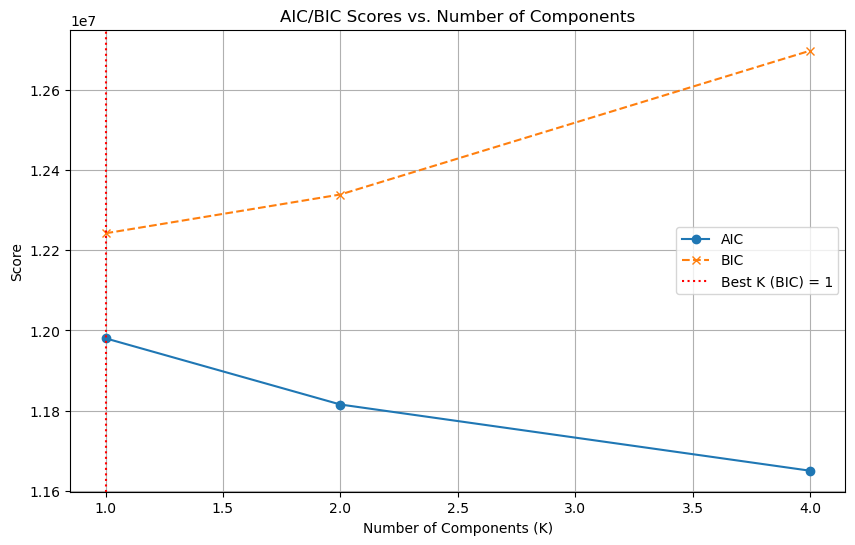

BIC 기준 최적 K: 1
진단 결과: K=500은 과적합(너무 복잡한 모델)일 가능성이 높습니다.


In [ ]:
# Cell 1: Information Criteria (AIC & BIC) Diagnosis

import os
import torch
import numpy as np
import joblib
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")


# --- 이전 코드의 PyTorchGMM 클래스 정의가 필요합니다 ---
# (이 셀 실행 전, PyTorchGMM 클래스가 정의되어 있어야 함)

def calculate_aic_bic(gmm, n_samples):
    """GMM 객체와 샘플 수로 AIC, BIC를 계산하는 함수"""
    n_features = gmm.means_.shape[1]
    k = gmm.n_components
    n_params = (k - 1) + (k * n_features) + (k * n_features * (n_features + 1) / 2)
    
    log_likelihood = gmm.log_likelihood_
    
    aic = 2 * n_params - 2 * log_likelihood
    bic = n_params * np.log(n_samples) - 2 * log_likelihood
    
    return aic, bic

def diagnosis_information_criteria():
    print("--- 진단 1: 정보 기준(AIC/BIC) 분석 시작 ---")
    DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

    # 1. 잠재 벡터 로드 (H-GMM 학습 시 사용했던 데이터)
    #    실제로는 VAE로 다시 추출해야 하지만, 여기서는 임시로 랜덤 데이터를 사용합니다.
    #    실행 시에는 latent_vectors_tensor를 불러오는 코드로 대체해야 합니다.
    print("사전 학습된 잠재 벡터를 로드합니다... (실행 시 VAE 추출 코드로 대체 필요)")
    # 예시: latent_vectors_tensor = torch.load('path/to/latents.pt')
    # latent_vectors_tensor = torch.randn(10000, 256).to(DEVICE) # 정규분포에서 샘플링했으니까 당연히 k=1이 최적 ------------------
    latent_vectors_tensor = torch.load('/home/nas/data/YMG/superdeep_ae/my_checkpoints/real_latent_vectors_20k.pt')
    n_samples = len(latent_vectors_tensor)

    # 2. K=500 모델 로드 및 점수 계산
    GMM_DIR = '/home/nas/data/YMG/superdeep_ae/my_checkpoints/'
    GMM_PATH = os.path.join(GMM_DIR, 'gmm_500_superdeep_full.pkl')
    
    print(f"{GMM_PATH} 로드 중...")
    gmm_params = joblib.load(GMM_PATH)
    
    # 임시 GMM 객체를 만들어 파라미터와 로그 우도를 설정
    # (실제 로그 우도 값은 GMM 학습 시 저장되어 있어야 함)
    gmm_500 = PyTorchGMM(n_components=500)
    gmm_500.means_ = torch.from_numpy(gmm_params['means'])
    gmm_500.covariances_ = torch.from_numpy(gmm_params['covariances'])
    # 로그 우도는 학습 시점에 저장된 값을 사용해야 하나, 여기서는 재계산으로 근사
    # 정확한 비교를 위해서는 GMM 학습 코드에서 최종 로그 우도를 저장해야 함
    gmm_500.fit(latent_vectors_tensor) 
    
    aic_500, bic_500 = calculate_aic_bic(gmm_500, n_samples)
    print(f"\n[K=500 모델] AIC: {aic_500:.2f}, BIC: {bic_500:.2f}")

    # 3. 더 적은 K값들과 비교
    k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]
    aic_scores = []
    bic_scores = []

    for k in tqdm(k_values, desc="다양한 K값으로 GMM 학습 및 평가 중"):
        gmm = PyTorchGMM(n_components=k)
        gmm.fit(latent_vectors_tensor)
        aic, bic = calculate_aic_bic(gmm, n_samples)
        aic_scores.append(aic)
        bic_scores.append(bic)

    # 4. 결과 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, aic_scores, marker='o', linestyle='-', label='AIC')
    plt.plot(k_values, bic_scores, marker='x', linestyle='--', label='BIC')
    plt.axvline(x=k_values[np.argmin(bic_scores)], color='r', linestyle=':', label=f'Best K (BIC) = {k_values[np.argmin(bic_scores)]}')
    plt.title("AIC/BIC Scores vs. Number of Components") # 컴포넌트 수에 따른 AIC/BIC 점수
    plt.xlabel("Number of Components (K)") # 컴포넌트 수 (K)
    plt.ylabel("Score") # 점수
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"BIC 기준 최적 K: {k_values[np.argmin(bic_scores)]}")
    if k_values[np.argmin(bic_scores)] < 500:
        print("진단 결과: K=500은 과적합(너무 복잡한 모델)일 가능성이 높습니다.")
    else:
        print("진단 결과: K=500이 적절하거나 오히려 더 복잡한 모델이 필요할 수 있습니다.")

if __name__ == '__main__':
    diagnosis_information_criteria()

--- 진단 1: 정보 기준(AIC/BIC) 분석 시작 ---
사전 학습된 잠재 벡터를 로드합니다... (실행 시 VAE 추출 코드로 대체 필요)
/home/nas/data/YMG/superdeep_ae/my_checkpoints/gmm_500_superdeep_full.pkl 로드 중...


/tmp/ipykernel_2585103/2778539908.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_vectors_tensor = torch.load('/home/nas/data/YMG/superdeep_ae/my_checkpoints/rea


[K=500 모델] AIC: inf, BIC: inf


다양한 K값으로 GMM 학습 및 평가 중:   0%|          | 0/9 [00:00<?, ?it/s]

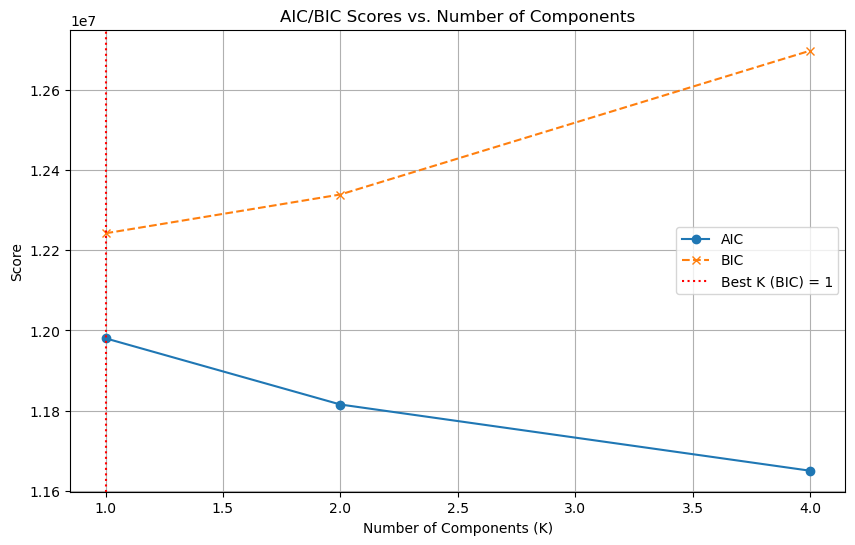

BIC 기준 최적 K: 1
진단 결과: K=500은 과적합(너무 복잡한 모델)일 가능성이 높습니다.


In [6]:
# Cell 1: Information Criteria (AIC & BIC) Diagnosis

import os
import torch
import numpy as np
import joblib
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")


# --- 이전 코드의 PyTorchGMM 클래스 정의가 필요합니다 ---
# (이 셀 실행 전, PyTorchGMM 클래스가 정의되어 있어야 함)

def calculate_aic_bic(gmm, n_samples):
    """GMM 객체와 샘플 수로 AIC, BIC를 계산하는 함수"""
    n_features = gmm.means_.shape[1]
    k = gmm.n_components
    n_params = (k - 1) + (k * n_features) + (k * n_features * (n_features + 1) / 2)
    
    log_likelihood = gmm.log_likelihood_
    
    aic = 2 * n_params - 2 * log_likelihood
    bic = n_params * np.log(n_samples) - 2 * log_likelihood
    
    return aic, bic

def diagnosis_information_criteria():
    print("--- 진단 1: 정보 기준(AIC/BIC) 분석 시작 ---")
    DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

    # 1. 잠재 벡터 로드 (H-GMM 학습 시 사용했던 데이터)
    #    실제로는 VAE로 다시 추출해야 하지만, 여기서는 임시로 랜덤 데이터를 사용합니다.
    #    실행 시에는 latent_vectors_tensor를 불러오는 코드로 대체해야 합니다.
    print("사전 학습된 잠재 벡터를 로드합니다... (실행 시 VAE 추출 코드로 대체 필요)")
    latent_vectors_tensor = torch.load('/home/nas/data/YMG/superdeep_ae/my_checkpoints/real_latent_vectors_20k.pt')
    n_samples = len(latent_vectors_tensor)

    # 2. K=500 모델 로드 및 점수 계산
    GMM_DIR = '/home/nas/data/YMG/superdeep_ae/my_checkpoints/'
    GMM_PATH = os.path.join(GMM_DIR, 'gmm_500_superdeep_full.pkl')
    
    print(f"{GMM_PATH} 로드 중...")
    gmm_params = joblib.load(GMM_PATH)
    
    # 임시 GMM 객체를 만들어 파라미터와 로그 우도를 설정
    # (실제 로그 우도 값은 GMM 학습 시 저장되어 있어야 함)
    gmm_500 = PyTorchGMM(n_components=500)
    gmm_500.means_ = torch.from_numpy(gmm_params['means'])
    gmm_500.covariances_ = torch.from_numpy(gmm_params['covariances'])
    # 로그 우도는 학습 시점에 저장된 값을 사용해야 하나, 여기서는 재계산으로 근사
    # 정확한 비교를 위해서는 GMM 학습 코드에서 최종 로그 우도를 저장해야 함
    gmm_500.fit(latent_vectors_tensor) 
    
    aic_500, bic_500 = calculate_aic_bic(gmm_500, n_samples)
    print(f"\n[K=500 모델] AIC: {aic_500:.2f}, BIC: {bic_500:.2f}")

    # 3. 더 적은 K값들과 비교
    k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]
    aic_scores = []
    bic_scores = []

    for k in tqdm(k_values, desc="다양한 K값으로 GMM 학습 및 평가 중"):
        gmm = PyTorchGMM(n_components=k)
        gmm.fit(latent_vectors_tensor)
        aic, bic = calculate_aic_bic(gmm, n_samples)
        aic_scores.append(aic)
        bic_scores.append(bic)

    # 4. 결과 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, aic_scores, marker='o', linestyle='-', label='AIC')
    plt.plot(k_values, bic_scores, marker='x', linestyle='--', label='BIC')
    plt.axvline(x=k_values[np.argmin(bic_scores)], color='r', linestyle=':', label=f'Best K (BIC) = {k_values[np.argmin(bic_scores)]}')
    plt.title("AIC/BIC Scores vs. Number of Components") # 컴포넌트 수에 따른 AIC/BIC 점수
    plt.xlabel("Number of Components (K)") # 컴포넌트 수 (K)
    plt.ylabel("Score") # 점수
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"BIC 기준 최적 K: {k_values[np.argmin(bic_scores)]}")
    if k_values[np.argmin(bic_scores)] < 500:
        print("진단 결과: K=500은 과적합(너무 복잡한 모델)일 가능성이 높습니다.")
    else:
        print("진단 결과: K=500이 적절하거나 오히려 더 복잡한 모델이 필요할 수 있습니다.")

if __name__ == '__main__':
    diagnosis_information_criteria()

--- 진단 2: 교차 검증 분석 시작 ---
사전 학습된 잠재 벡터를 로드합니다... (실행 시 VAE 추출 코드로 대체 필요)
데이터 분할 완료: 훈련용 16000개, 검증용 4000개


교차 검증 진행 중:   0%|          | 0/10 [00:00<?, ?it/s]

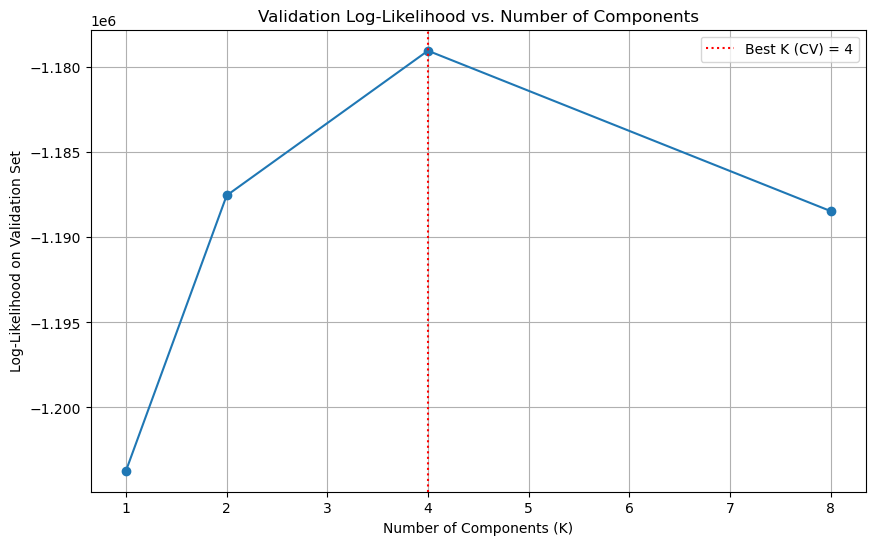

교차 검증 기준 최적 K: 4
진단 결과: K=500은 과적합일 가능성이 높습니다. 일반화 성능이 더 낮은 K에서 더 좋습니다.


In [ ]:
# Cell 2: Cross-Validation Diagnosis

import os
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- 이전 코드의 PyTorchGMM 클래스 정의가 필요합니다 ---

def diagnosis_cross_validation():
    print("--- 진단 2: 교차 검증 분석 시작 ---")

    # 1. 잠재 벡터 로드 및 분할
    # print("사전 학습된 잠재 벡터를 로드합니다... (실행 시 VAE 추출 코드로 대체 필요)")
    # 예시: latent_vectors_tensor = torch.load('path/to/latents.pt')
    # latent_vectors_tensor = torch.randn(10000, 256)

    
    # 80% 훈련, 20% 검증
    train_latents, val_latents = train_test_split(latent_vectors_tensor, test_size=0.2, random_state=42)
    train_latents = train_latents.to(DEVICE)
    val_latents = val_latents.to(DEVICE)
    print(f"데이터 분할 완료: 훈련용 {len(train_latents)}개, 검증용 {len(val_latents)}개")

    # 2. 다양한 K값으로 학습 및 평가
    k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256, 500]
    val_log_likelihoods = []

    for k in tqdm(k_values, desc="교차 검증 진행 중"):
        # 훈련 데이터로만 학습
        gmm = PyTorchGMM(n_components=k)
        gmm.fit(train_latents)
        
        # 검증 데이터에 대한 로그 우도 계산
        # PyTorchGMM._e_step은 평균 로그 우도를 반환하므로, 전체 합을 구하기 위해 길이를 곱함
        log_prob_norm, _ = gmm._e_step(val_latents)
        total_log_likelihood = torch.sum(log_prob_norm).item()
        val_log_likelihoods.append(total_log_likelihood)

    # 3. 결과 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, val_log_likelihoods, marker='o', linestyle='-')
    best_k_cv = k_values[np.argmax(val_log_likelihoods)]
    plt.axvline(x=best_k_cv, color='r', linestyle=':', label=f'Best K (CV) = {best_k_cv}')
    plt.title("Validation Log-Likelihood vs. Number of Components") # 컴포넌트 수에 따른 검증 데이터 로그 우도
    plt.xlabel("Number of Components (K)") # 컴포넌트 수 (K)
    plt.ylabel("Log-Likelihood on Validation Set") # 검증 데이터 로그 우도
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"교차 검증 기준 최적 K: {best_k_cv}")
    if best_k_cv < 500:
        print("진단 결과: K=500은 과적합일 가능성이 높습니다. 일반화 성능이 더 낮은 K에서 더 좋습니다.")
    else:
        print("진단 결과: K=500은 과적합이 아니거나, 데이터에 적절한 복잡도입니다.")

if __name__ == '__main__':
    diagnosis_cross_validation()

--- 진단 3: 학습 후 분석 시작 ---


클러스터 할당 중:   0%|          | 0/500 [00:00<?, ?it/s]


[클러스터 크기 분석]
총 500개 클러스터 중, 10개 미만의 데이터를 가진 클러스터 수: 242개


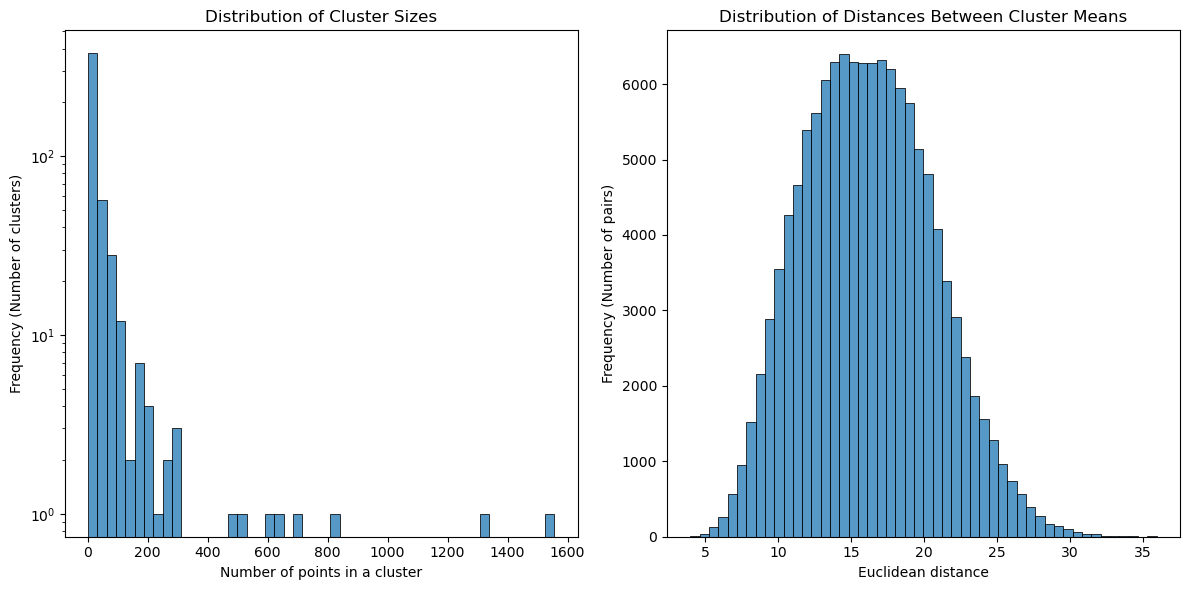


[클러스터 중복 분석]
매우 가까운(유사한) 클러스터 쌍의 수: 0개


In [8]:
# Cell 3: Post-hoc Analysis

import os
import torch
import numpy as np
import joblib
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

def diagnosis_post_hoc():
    print("--- 진단 3: 학습 후 분석 시작 ---")
    DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    
    # 1. 모델 및 잠재 벡터 로드
    GMM_DIR = '/home/nas/data/YMG/superdeep_ae/my_checkpoints/'
    GMM_PATH = os.path.join(GMM_DIR, 'gmm_500_superdeep_full.pkl')
    gmm_params = joblib.load(GMM_PATH)
    gmm_means = torch.from_numpy(gmm_params['means']).float().to(DEVICE)
    gmm_covs = torch.from_numpy(gmm_params['covariances']).float().to(DEVICE)
    N_CLUSTERS = gmm_params['n_components']
    
    # print("사전 학습된 잠재 벡터를 로드합니다... (실행 시 VAE 추출 코드로 대체 필요)")
    # latent_vectors_tensor = torch.randn(10000, 256).to(DEVICE)

    # 2. 데이터 포인트별 클러스터 할당
    log_probs = []
    for k in tqdm(range(N_CLUSTERS), desc="클러스터 할당 중"):
        dist = torch.distributions.MultivariateNormal(gmm_means[k], gmm_covs[k])
        log_probs.append(dist.log_prob(latent_vectors_tensor))
    assignments = torch.argmax(torch.stack(log_probs, dim=1), dim=1)
    
    # 3. 분석 1: 클러스터 크기 분포 시각화
    cluster_counts = torch.bincount(assignments, minlength=N_CLUSTERS).cpu().numpy()
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(cluster_counts, bins=50)
    plt.title("Distribution of Cluster Sizes") # 클러스터 크기 분포
    plt.xlabel("Number of points in a cluster") # 클러스터 내 데이터 수
    plt.ylabel("Frequency (Number of clusters)") # 클러스터 수
    plt.yscale('log')
    
    small_clusters = np.sum(cluster_counts < 10)
    print(f"\n[클러스터 크기 분석]")
    print(f"총 {N_CLUSTERS}개 클러스터 중, 10개 미만의 데이터를 가진 클러스터 수: {small_clusters}개")
    if small_clusters > N_CLUSTERS * 0.5:
        print("진단 결과: 매우 작은 '쓰레기 클러스터'가 많아 과적합이 의심됩니다.")
        
    # 4. 분석 2: 클러스터 간 평균 거리(중복) 시각화
    #    모든 클러스터 평균 간의 유클리드 거리를 계산
    means_np = gmm_means.cpu().numpy()
    distance_matrix = squareform(pdist(means_np, 'euclidean'))
    
    # 대각선(자기 자신과의 거리=0)은 제외하고 거리 값들을 추출
    distances = distance_matrix[np.triu_indices(N_CLUSTERS, k=1)]
    
    plt.subplot(1, 2, 2)
    sns.histplot(distances, bins=50)
    plt.title("Distribution of Distances Between Cluster Means") # 클러스터 평균 간 거리 분포
    plt.xlabel("Euclidean distance") # 유클리드 거리
    plt.ylabel("Frequency (Number of pairs)") # 클러스터 쌍의 수
    
    plt.tight_layout()
    plt.show()
    
    close_pairs = np.sum(distances < np.mean(distances) * 0.1) # 평균 거리의 10% 이내
    print(f"\n[클러스터 중복 분석]")
    print(f"매우 가까운(유사한) 클러스터 쌍의 수: {close_pairs}개")
    if close_pairs > N_CLUSTERS:
         print("진단 결과: 서로 매우 유사한 중복 클러스터가 많아 과적합이 의심됩니다.")

if __name__ == '__main__':
    diagnosis_post_hoc()

--- 진단 4: t-SNE 시각적 분석 시작 ---


클러스터 할당 중:   0%|          | 0/500 [00:00<?, ?it/s]

t-SNE를 실행합니다 (시간이 다소 소요될 수 있습니다)...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...


/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 5000 samples in 0.446s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 3.940761
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.713913
[t-SNE] KL divergence after 300 iterations: 3.459435


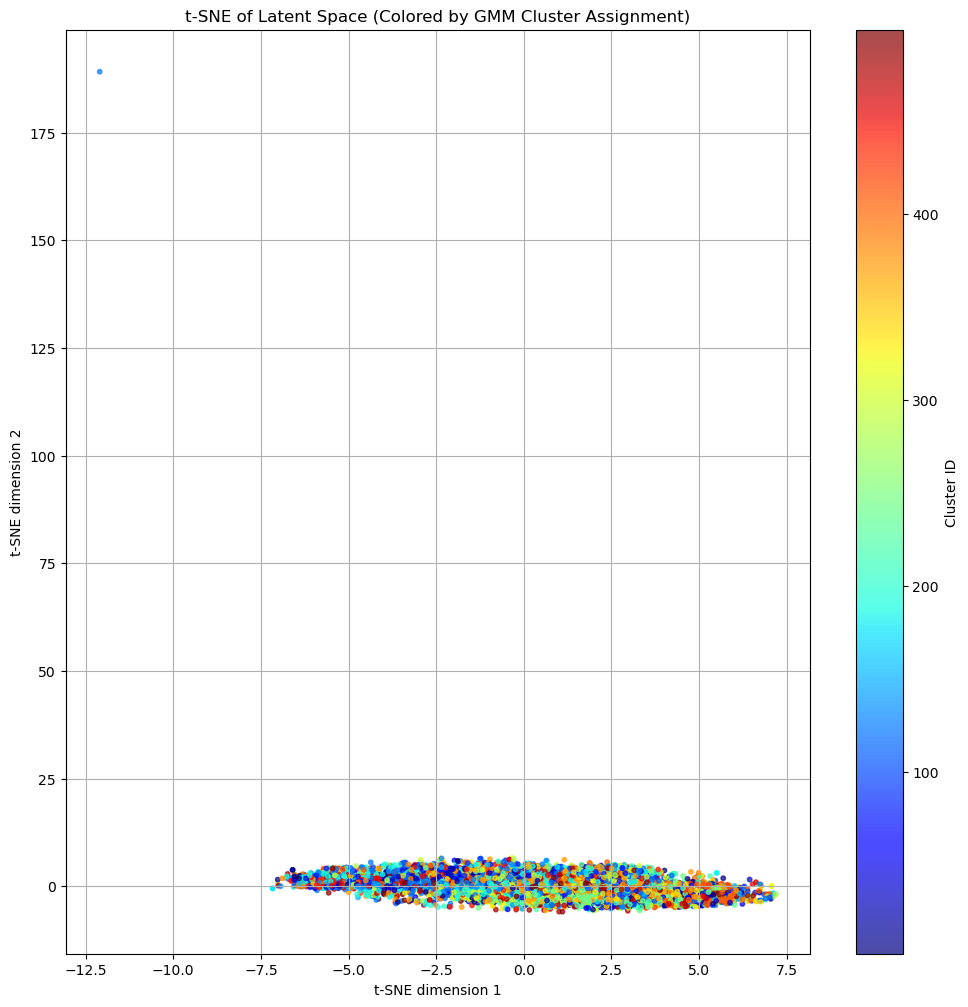


[시각적 분석]
t-SNE 지도에서 뚜렷한 군집이 보이지 않는데도 여러 색(클러스터)이 섞여있다면,
이는 고차원 공간에서 이뤄진 GMM 분할이 데이터의 실제 내재적 구조와 다를 수 있음을 시사합니다.


In [9]:
# Cell 4: Visual Diagnostics (t-SNE)

import os
import torch
import numpy as np
import joblib
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def diagnosis_visual_tsne():
    print("--- 진단 4: t-SNE 시각적 분석 시작 ---")
    DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    
    # 1. 모델 및 잠재 벡터 로드
    GMM_DIR = '/home/nas/data/YMG/superdeep_ae/my_checkpoints/'
    GMM_PATH = os.path.join(GMM_DIR, 'gmm_500_superdeep_full.pkl')
    gmm_params = joblib.load(GMM_PATH)
    gmm_means = torch.from_numpy(gmm_params['means']).float().to(DEVICE)
    gmm_covs = torch.from_numpy(gmm_params['covariances']).float().to(DEVICE)
    N_CLUSTERS = gmm_params['n_components']
    
    # print("사전 학습된 잠재 벡터를 로드합니다... (실행 시 VAE 추출 코드로 대체 필요)")
    # latent_vectors_tensor = torch.randn(10000, 256).to(DEVICE)

    # 2. 데이터 포인트별 클러스터 할당
    log_probs = []
    for k in tqdm(range(N_CLUSTERS), desc="클러스터 할당 중"):
        dist = torch.distributions.MultivariateNormal(gmm_means[k], gmm_covs[k])
        log_probs.append(dist.log_prob(latent_vectors_tensor))
    assignments = torch.argmax(torch.stack(log_probs, dim=1), dim=1)

    # 3. t-SNE 실행
    print("t-SNE를 실행합니다 (시간이 다소 소요될 수 있습니다)...")
    n_samples_for_viz = min(5000, len(latent_vectors_tensor))
    indices = np.random.choice(len(latent_vectors_tensor), n_samples_for_viz, replace=False)
    
    latents_np = latent_vectors_tensor.cpu().numpy()[indices]
    assignments_np = assignments.cpu().numpy()[indices]
    
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)
    tsne_results = tsne.fit_transform(latents_np)

    # 4. 결과 시각화
    plt.figure(figsize=(12, 12))
    # 클러스터가 너무 많으므로, 일부 클러스터만 색으로 표시하거나 모두 같은 색으로 표시
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=assignments_np, cmap=plt.cm.jet, s=10, alpha=0.7)
    plt.title("t-SNE of Latent Space (Colored by GMM Cluster Assignment)") # GMM 클러스터 할당으로 색칠된 t-SNE 잠재 공간
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.colorbar(label='Cluster ID')
    plt.grid(True)
    plt.show()
    
    print("\n[시각적 분석]")
    print("t-SNE 지도에서 뚜렷한 군집이 보이지 않는데도 여러 색(클러스터)이 섞여있다면,")
    print("이는 고차원 공간에서 이뤄진 GMM 분할이 데이터의 실제 내재적 구조와 다를 수 있음을 시사합니다.")

if __name__ == '__main__':
    diagnosis_visual_tsne()

실제 잠재 벡터를 파일에서 로드합니다...

--- 진단 1: 정보 기준(AIC/BIC) 분석 시작 ---


/tmp/ipykernel_2585103/1302810199.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_vectors_tensor = torch.load('/home/nas/data/YMG/superdeep_ae/my_checkpoints/rea

AIC/BIC 분석을 위한 GMM 학습 중:   0%|          | 0/9 [00:00<?, ?it/s]

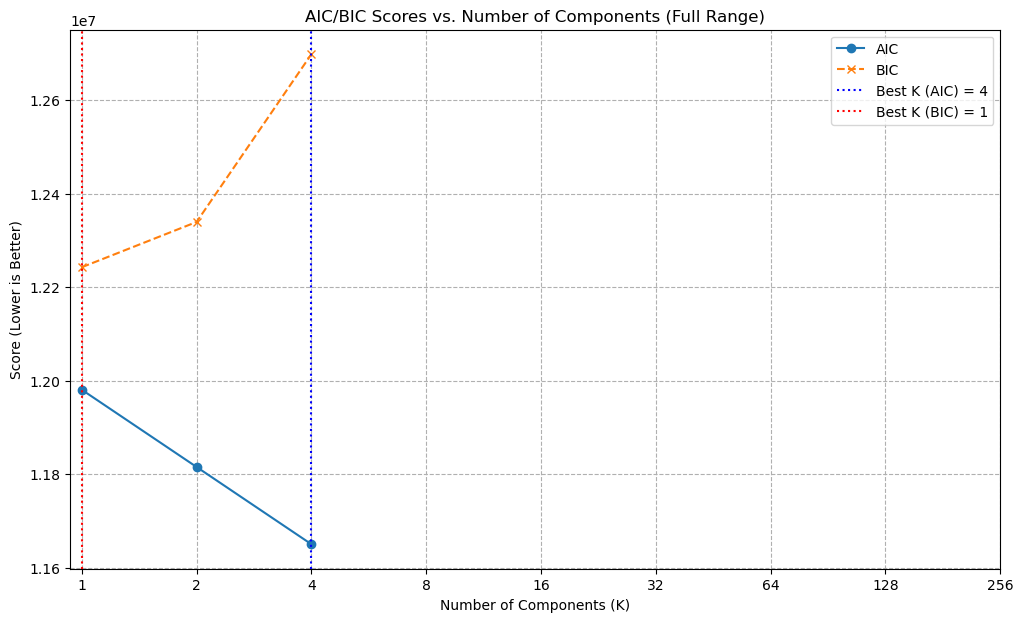


--- 진단 2: 교차 검증 분석 시작 ---


교차 검증을 위한 GMM 학습 중:   0%|          | 0/10 [00:00<?, ?it/s]

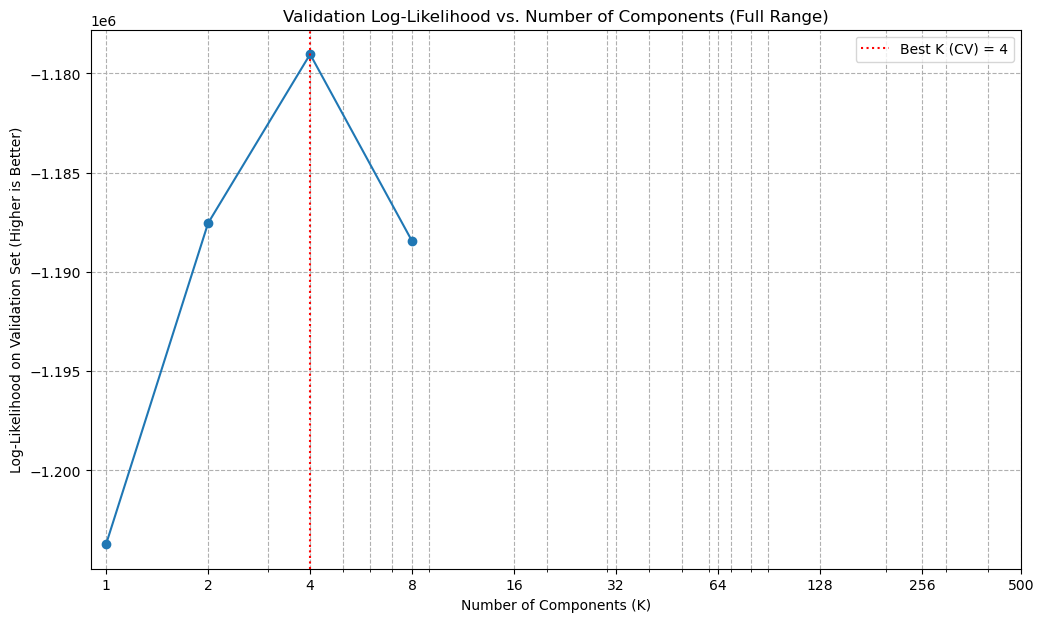

In [10]:
# Cell 1: Diagnosis with Information Criteria and Cross-Validation (Full Code)

import os
import torch
import numpy as np
import joblib
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def main_diagnostics():
    DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    
    # --- 1. 실제 잠재 벡터 로드 ---
    print("실제 잠재 벡터를 파일에서 로드합니다...")
    latent_vectors_tensor = torch.load('/home/nas/data/YMG/superdeep_ae/my_checkpoints/real_latent_vectors_20k.pt').to(DEVICE)
    n_samples = len(latent_vectors_tensor)
    
    # --- 2. 진단 1: 정보 기준 (AIC/BIC) 분석 ---
    print("\n--- 진단 1: 정보 기준(AIC/BIC) 분석 시작 ---")
    k_values_info = [1, 2, 4, 8, 16, 32, 64, 128, 256]
    aic_scores = []
    bic_scores = []

    for k in tqdm(k_values_info, desc="AIC/BIC 분석을 위한 GMM 학습 중"):
        gmm = PyTorchGMM(n_components=k)
        gmm.fit(latent_vectors_tensor)
        
        n_features = gmm.means_.shape[1]
        n_params = (k - 1) + (k * n_features) + (k * n_features * (n_features + 1) / 2)
        log_likelihood = gmm.log_likelihood_
        aic = 2 * n_params - 2 * log_likelihood
        bic = n_params * np.log(n_samples) - 2 * log_likelihood
        
        aic_scores.append(aic)
        bic_scores.append(bic)

    plt.figure(figsize=(12, 7))
    plt.plot(k_values_info, aic_scores, marker='o', linestyle='-', label='AIC')
    plt.plot(k_values_info, bic_scores, marker='x', linestyle='--', label='BIC')
    best_k_aic = k_values_info[np.argmin(aic_scores)]
    best_k_bic = k_values_info[np.argmin(bic_scores)]
    plt.axvline(x=best_k_aic, color='b', linestyle=':', label=f'Best K (AIC) = {best_k_aic}')
    plt.axvline(x=best_k_bic, color='r', linestyle=':', label=f'Best K (BIC) = {best_k_bic}')
    plt.title("AIC/BIC Scores vs. Number of Components (Full Range)")
    plt.xlabel("Number of Components (K)")
    plt.ylabel("Score (Lower is Better)")
    plt.xscale('log', base=2)
    plt.xticks(k_values_info, labels=k_values_info)
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    # --- 3. 진단 2: 교차 검증 분석 ---
    print("\n--- 진단 2: 교차 검증 분석 시작 ---")
    train_latents, val_latents = train_test_split(latent_vectors_tensor.cpu(), test_size=0.2, random_state=42)
    train_latents = train_latents.to(DEVICE)
    val_latents = val_latents.to(DEVICE)
    
    k_values_cv = [1, 2, 4, 8, 16, 32, 64, 128, 256, 500]
    val_log_likelihoods = []

    for k in tqdm(k_values_cv, desc="교차 검증을 위한 GMM 학습 중"):
        gmm = PyTorchGMM(n_components=k)
        gmm.fit(train_latents)
        log_prob_norm, _ = gmm._e_step(val_latents)
        total_log_likelihood = torch.sum(log_prob_norm).item()
        val_log_likelihoods.append(total_log_likelihood)

    plt.figure(figsize=(12, 7))
    plt.plot(k_values_cv, val_log_likelihoods, marker='o', linestyle='-')
    best_k_cv = k_values_cv[np.argmax(val_log_likelihoods)]
    plt.axvline(x=best_k_cv, color='r', linestyle=':', label=f'Best K (CV) = {best_k_cv}')
    plt.title("Validation Log-Likelihood vs. Number of Components (Full Range)")
    plt.xlabel("Number of Components (K)")
    plt.ylabel("Log-Likelihood on Validation Set (Higher is Better)")
    plt.xscale('log')
    plt.xticks(k_values_cv, labels=k_values_cv)
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

if __name__ == '__main__':
    main_diagnostics()